## RUN ON SIM

In [26]:
from qiskit import *

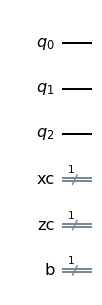

In [27]:
qreg_q = QuantumRegister(3, 'q')
creg_xc = ClassicalRegister(1, 'xc')
creg_zc = ClassicalRegister(1, 'zc')
creg_b  = ClassicalRegister(1, 'b')
circuit = QuantumCircuit(qreg_q, creg_xc, creg_zc,creg_b)
circuit.draw(output='mpl')

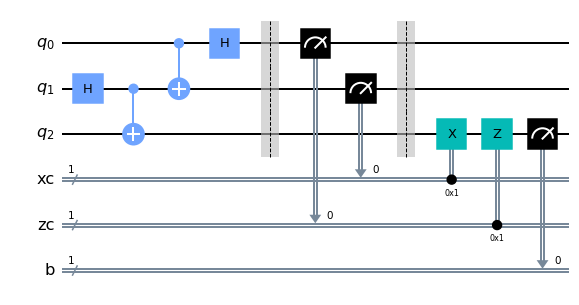

In [28]:
circuit.h(qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2])
circuit.measure(qreg_q[0], creg_zc[0])
circuit.measure(qreg_q[1], creg_xc[0])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2])
circuit.x(2).c_if(creg_xc, 1)
circuit.z(2).c_if(creg_zc, 1)
circuit.measure(qreg_q[2], creg_b[0])
circuit.draw(output='mpl')

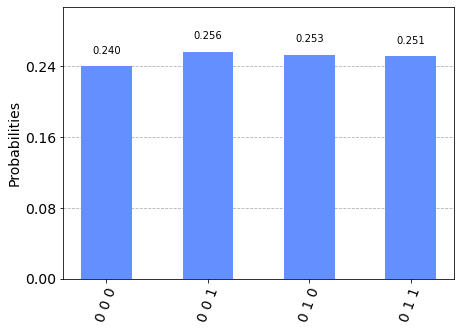

In [29]:
from qiskit.tools.visualization import plot_histogram
simulator = Aer.get_backend('qasm_simulator')
# transpile our circuit for the selected backend

result = execute(circuit, backend=simulator, shots=1000).result()
counts = result.get_counts()
plot_histogram(counts)

## TO RUN ON IBMQ

In [45]:
# Fucntions

def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target
    


def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)


def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)



def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)






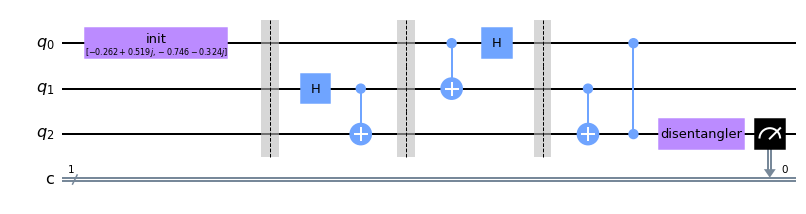

In [46]:
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector

# Create random 1-qubit state
psi = random_statevector(2)



init_gate = Initialize(psi)
init_gate.label = "init"

inverse_init_gate = init_gate.gates_to_uncompute()



qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()


Job Status: job has successfully run
{'0': 3538, '1': 462}


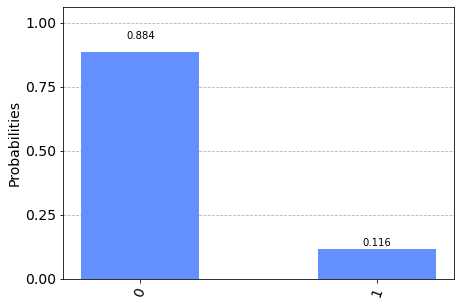

In [47]:


# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')



# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)
job_monitor(job)  # displays job status under cell

exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)


## Reference: https://github.com/qiskit-community/qiskit-textbook/blob/main/content/ch-algorithms/teleportation.ipynb